# Active Inference Demo: Epistemic Chaining

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/cue_chaining_demo.ipynb)

*Author: Conor Heins*

This demo notebook builds a generative model from scratch, constructs an `Agent` instance using the constructed generative model, and then runs an active inference simulation in a simple environment.

The environment used here is similar in spirit to the [T-Maze demo](https://pymdp-rtd.readthedocs.io/en/latest/notebooks/tmaze_demo.html), but the task structure is more complex. Here, we analogize the agent to a rat tasked with solving a spatial puzzle. The rat must sequentially visit a sequence of two cues located at different locations in a 2-D grid world, in order to ultimately reveal the locations of two (opposite) reward outcomes: one location will give the rat a reward ("Cheese") and the other location will give the rat a punishment ("Shock").

Using active inference to solve a POMDP representation of this task, the rat can successfully forage the correct cues in sequence, in order to ultimately discover the location of the "Cheese", and avoid the "Shock".

*Note*: When running this notebook in Google Colab, you may have to run `!pip install inferactively-pymdp` at the top of the notebook, before you can `import pymdp`. That cell is left commented out below, in case you are running this notebook from Google Colab.

In [23]:
! pip install inferactively-pymdp

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


### Imports

In [24]:
import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

## Grid World Parameters
Let's begin by initializing several variables related to the physical environment inhabited by the agent. These variables will encode things like the dimensions of the grid, the possible locations of the different cues, and the possible locations of the reward or punishment.

Having these variables defined will also come in handy when setting up the generative model of our agent and when creating the environment class.

We will create a grid world with dimensions $5 \times 7$. Particular locations of the grid are indexed as (y, x) tuples, that select a particular row and column respectively of that location in the grid.

By design of the task, one location in the grid world contain a cue: **Cue 1**. There will be four additional locations, that will serve as possible locations for a second cue: **Cue 2**. Crucially, only *one* of these four additional locations will actually contain **Cue 2** - the other 3 will be empty. When the agent visits **Cue 1** by moving to its location, one of four signals is presented, which each unambiguously signal which of the 4 possible locations **Cue 2** occupies -- we can refer to these Cue-2-location-signals with obvious names: `L1`, `L2`, `L3`, `L4`. Once **Cue 2**'s location has been revealed, by visiting that location the agent will then receive one of two possible signals, that indicate where the hidden reward is located (and conversely, where the hidden punishment lies). These two possible reward/punishment locations are indicated by two locations: "TOP" (meaning the "Cheese" reward is on the upper of the two locations) or "BOTTOM" (meaning the "Cheese" reward is on the lower of the two locations).

In this way, the most efficient and risk-sensitive way to achieve reward in this task is to first visit **Cue 1**, in order to figure out the location of **Cue 2**, in order to figure out the location of the reward.

*Tip*: When setting up `pymdp` generative models and task environments, we recommend creating additional variables, like lists of strings or dicts with string-valued keys, that help you relate the values of various aspects of the task to semantically-meaning labels. These come in handy when generating print statements during debugging or labels for plotting. For example, below we create a list called `reward_conditions` that stores the "names" of the two reward conditions: `"TOP"` and `"BOTTOM"`

In [25]:
grid_dims = [5, 7] # dimensions of the grid (number of rows, number of columns)
num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

# create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

# (y, x) coordinate of the first cue's location, and then a list of the (y, x) coordinates of the possible locations of the second cue, and their labels (`L1`, `L2`, ...)
cue1_location = (2, 0)

cue2_loc_names = ['L1', 'L2', 'L3', 'L4']
cue2_locations = [(0, 2), (1, 3), (3, 3), (4, 2)]

# names of the reward conditions and their locations
reward_conditions = ["TOP", "BOTTOM"]
reward_locations = [(1, 5), (3, 5)]


### Visualize the grid world

Let's quickly use the variables we just defined to visualize the grid world, including the **Cue 1** location, the possible **Cue 2** locations, and the possible reward locations (in gray, since we don't know which one has the "Cheese" and which one has the "Shock")


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


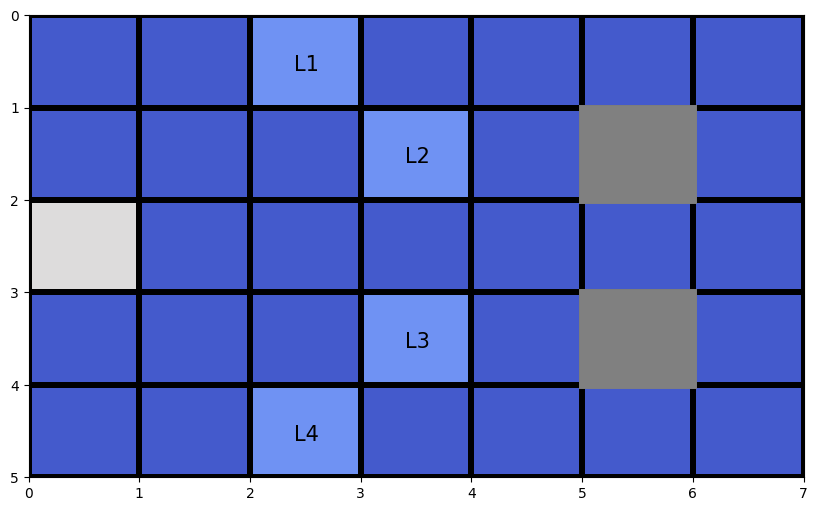

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10, 6))

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

# Put gray boxes around the possible reward locations
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor=[0.5, 0.5, 0.5]))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor=[0.5, 0.5, 0.5]))

text_offsets = [0.4, 0.6]

cue_grid = np.ones(grid_dims)
cue_grid[cue1_location[0],cue1_location[1]] = 15.0
for ii, loc_ii in enumerate(cue2_locations):
  row_coord, column_coord = loc_ii
  cue_grid[row_coord, column_coord] = 5.0
  ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], cue2_loc_names[ii], fontsize = 15, color='k')
h.set_array(cue_grid.ravel())



## Generative model

The hidden states $\mathbf{s}$ of the generative model are factorized into three hidden states factors:

1. a **Location** hidden state factor with as many levels as there are grid locations. This encodes the agent's location in the grid world.
2. a **Cue 2 Location** hidden state factor with 4 levels -- this encodes in which of the four possible locations **Cue 2** is located.
3. a **Reward Condition** hidden state factor with 2 levels -- this encodes which of the two reward locations ("TOP" or "BOTTOM") the "Cheese" is to be found in. When the **Reward Condition** level is "TOP", then the "Cheese" reward is the upper of the two locations, and the "Shock" punishment is on the lower of the two locations. The locations are switched in the "BOTTOM" level of the **Reward Condition** factor.

The observations $\mathbf{o}$ of the generative model are factorized into four different observation modalities:

1. a **Location** observation modality with as many levels as there are grid locations, representing the agent's observation of its location in the grid world.
2. a **Cue 1** observation modality with 5 levels -- this is an observation, only obtained at the **Cue 1** location, that signals in which of the 4 possible locations **Cue 2** is located. When not at the **Cue 1** location, the agent sees `Null` or a meaningless observation.
3. a **Cue 2** observation modality with 3 levels -- this is an observation, only obtained at the **Cue 2** location, that signals in which of the two reward locations ("TOP" or "BOTTOM") the "Cheese" is located. When not at the **Cue 2** location, the agent sees `Null` or a meaningless observation.
4. a **Reward** observation modality with 3 levels -- this is an observation that signals whether the agent is receiving "Cheese", "Shock" or nothing at all ("Null"). The agent only receives "Cheese" or "Shock" when occupying one of the two reward locations, and `Null` otherwise.


As is the usual convention in `pymdp`, let's create a list that contains the dimensionalities of the hidden state factors, named `num_states`, and a list that contains the dimensionalities of the observation modalities, named `num_obs`.

In [27]:
# list of dimensionalities of the hidden states -- useful for creating generative model later on
num_states = [num_grid_points, len(cue2_locations), len(reward_conditions)]

# Names of the cue1 observation levels, the cue2 observation levels, and the reward observation levels
cue1_names = ['Null'] + cue2_loc_names # signals for the possible Cue 2 locations, that only are seen when agent is visiting Cue 1
cue2_names = ['Null', 'reward_on_top', 'reward_on_bottom']
reward_names = ['Null', 'Cheese', 'Shock']

num_obs = [num_grid_points, len(cue1_names), len(cue2_names), len(reward_names)]

### The observation model: **A** array
Now using `num_states` and `num_obs` we can initialize `A`, the observation model

In [28]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs] # list of shapes of modality-specific A[m] arrays
A = utils.obj_array_zeros(A_m_shapes) # initialize A array to an object array of all-zero subarrays

Let's fill out the various modalities of the `A` array, encoding the agents beliefs about how hidden states probabilistically cause observations within each modality.

Starting with the `0`-th modality, the **Location** observation modality: `A[0]`

In [29]:
# make the location observation only depend on the location state (proprioceptive observation modality)
A[0] = np.tile(np.expand_dims(np.eye(num_grid_points), (-2, -1)), (1, 1, num_states[1], num_states[2]))

Now we can build the `1`-st modality, the **Cue 1** observation modality: `A[1]`

In [30]:
# make the cue1 observation depend on the location (being at cue1_location) and the true location of cue2
A[1][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

# Make the Cue 1 signal depend on 1) being at the Cue 1 location and 2) the location of Cue 2
for i, cue_loc2_i in enumerate(cue2_locations):
    A[1][0,loc_list.index(cue1_location),i,:] = 0.0
    A[1][i+1,loc_list.index(cue1_location),i,:] = 1.0

Now we can build the `2`-nd modality, the **Cue 2** observation modality: `A[2]`

In [31]:
# make the cue2 observation depend on the location (being at the correct cue2_location) and the reward condition
A[2][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

for i, cue_loc2_i in enumerate(cue2_locations):

    # if the cue2-location is the one you're currently at, then you get a signal about where the reward is
    A[2][0,loc_list.index(cue_loc2_i),i,:] = 0.0
    A[2][1,loc_list.index(cue_loc2_i),i,0] = 1.0
    A[2][2,loc_list.index(cue_loc2_i),i,1] = 1.0

Finally, we build the 3rd modality, the **Reward** observation modality: `A[3]`

In [32]:
# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[3][0,rew_top_idx,:,:] = 0.0
A[3][1,rew_top_idx,:,0] = 1.0
A[3][2,rew_top_idx,:,1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" reward location
A[3][0,rew_bott_idx,:,:] = 0.0
A[3][1,rew_bott_idx,:,1] = 1.0
A[3][2,rew_bott_idx,:,0] = 1.0

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


### The transition model: **B** array
To create the `B` array or transition model, we have to further specify `num_controls`, which like `num_states` / `num_obs` is a list, but this time of the dimensionalities of each *control factor*, which are the hidden state factors that are controllable by the agent. Uncontrollable hidden state factors can be encoded as control factors of dimension 1. Once `num_controls` is defined, we can then use it and `num_states` to specify the dimensionality of the `B` arrays. Recall that in `pymdp` hidden state factors are conditionally independent of eachother, meaning that each sub-array `B[f]` describes the dynamics of only a single hidden state factor, and its probabilistic dependence on both its own state (at the previous time) and the state of its corresponding control factor.

In the current grid world task, we will have the agent have the ability to make movements in the 4 cardinal directions (UP, DOWN, LEFT, RIGHT) as well as the option to stay in the same place (STAY). This means we will associate a single 5-dimensional control state factor with the first hidden state factor.

*Note*: Make sure the indices of the `num_controls` variables "lines up" with those of `num_states`.

In [33]:
# initialize `num_controls`
num_controls = [5, 1, 1]

# initialize the shapes of each sub-array `B[f]`
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]

# create the `B` array and fill it out
B = utils.obj_array_zeros(B_f_shapes)

Fill out `B[0]` according to the expected consequences of each of the 5 actions. Note that we also create a list that stores the names of each action, for interpretability.

In [34]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

# fill out `B[0]` using the
for action_id, action_label in enumerate(actions):

  for curr_state, grid_location in enumerate(loc_list):

    y, x = grid_location

    if action_label == "UP":
      next_y = y - 1 if y > 0 else y
      next_x = x
    elif action_label == "DOWN":
      next_y = y + 1 if y < (grid_dims[0]-1) else y
      next_x = x
    elif action_label == "LEFT":
      next_x = x - 1 if x > 0 else x
      next_y = y
    elif action_label == "RIGHT":
      next_x = x + 1 if x < (grid_dims[1]-1) else x
      next_y = y
    elif action_label == "STAY":
      next_x = x
      next_y = y

    new_location = (next_y, next_x)
    next_state = loc_list.index(new_location)
    B[0][next_state, curr_state, action_id] = 1.0

Fill out `B[1]` and `B[2]` as identity matrices, encoding the fact that those hidden states are uncontrollable

In [35]:
B[1][:,:,0] = np.eye(num_states[1])
B[2][:,:,0] = np.eye(num_states[2])

### Prior preferences: the **C** vectors

Now we specify the agent's prior over observations, also known as the "prior preferences" or "goal vector." This is not technically a part of the same generative model used for inference of hidden states, but part of a special predictive generative model using for policy inference.

Since the prior preferences are defined in `pymdp` as priors over observations, not states, so `C` will be an object array whose sub-arrays correspond to the priors over specific observation modalities, e.g `C[3]` encodes the prior preferences for different levels of the **Reward** observation modality.

In [36]:
C = utils.obj_array_zeros(num_obs)

C[3][1] = 2.0 # make the agent want to encounter the "Cheese" observation level
C[3][2] = -4.0 # make the agent not want to encounter the "Shock" observation level

### Prior over (initial) hidden states: the **D** vectors

Now we specify the agent's prior over initial hidden states, the `D` array. Since it's defined over the multi-factor hidden states in this case, `D` will be an object array whose sub-arrays correspond to the priors over specific hidden state factors, e.g `D[0]` encodes the prior beliefs over the initial location of the agent in the grid world.

In [37]:
D = utils.obj_array_uniform(num_states)
D[0] = utils.onehot(loc_list.index((0,0)), num_grid_points)

## Generative process

Now we need to write down the "rules" of the game, i.e. the environment that the agent will actually be interacting with. The most concise way to do this in `pymdp` is by adopting a similar format to what's used in frameworks like OpenAIGym -- namely, we create an `env` class that takes actions as inputs to a `self.step()` method, and returns observations for the agent as outputs. In Active inference we refer to this agent-independent, physical "reality" in which the agent operates as the *generative process*, to be distinguished from the agent's representation of that reality the *generative model* (the `A`, `B`, `C` and `D` that we just wrote down above).

### Writing a custom `env`

Now we'll define an environment class called `GridWorldEnv`. The constructor for this class allows you to establish various parameters of the generative process, like where the agent starts in the grid-world at the beginning of the trial (`starting_loc`), the location of **Cue 1** (`cue1_loc`), the location of **Cue 2** (`cue2_loc`), and the reward condition (`reward_condition`).

*Note*: Remember the distinction between the generative model and the generative process: one can build the environment class to be as arbitrarily different from the agent's generative model as desired. For example, for the `GridWorldEnv` example, you could construct the agent's `A` array such that the agent *believes* **Cue 1** is in Location `(1,0)`, but in fact the cue is located somewhere else like `(3,0)` (as would be set by the `cue1_loc` argument to the `GridWorldEnv` constructor). Similarly, one could write the internal `step` method of the `GridWorldEnv` class so that the way the `reward_condition` is signalled is opposite from what the agent expects -- so when the agent sees a particular signal at the **Cue 2** location, they *assume* (via the `A` array) it means that the "Cheese" is located on the `"TOP"` location, but in fact the rule is switched so that "Shock" is at the `"TOP"` location in reality, and "Cheese" is actually at the `"BOTTOM"` location.

In [38]:
class GridWorldEnv():

    def __init__(self,starting_loc = (0,0), cue1_loc = (2, 0), cue2 = 'L1', reward_condition = 'TOP'):

        self.init_loc = starting_loc
        self.current_location = self.init_loc

        self.cue1_loc = cue1_loc
        self.cue2_name = cue2
        self.cue2_loc_names = ['L1', 'L2', 'L3', 'L4']
        self.cue2_loc = cue2_locations[self.cue2_loc_names.index(self.cue2_name)]

        self.reward_condition = reward_condition
        print(f'Starting location is {self.init_loc}, Reward condition is {self.reward_condition}, cue is located in {self.cue2_name}')

    def step(self,action_label):

        (Y, X) = self.current_location

        if action_label == "UP":

          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN":

          Y_new = Y + 1 if Y < (grid_dims[0]-1) else Y
          X_new = X

        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X +1 if X < (grid_dims[1]-1) else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new) # store the new grid location

        loc_obs = self.current_location # agent always directly observes the grid location they're in

        if self.current_location == self.cue1_loc:
          cue1_obs = self.cue2_name
        else:
          cue1_obs = 'Null'

        if self.current_location == self.cue2_loc:
          cue2_obs = cue2_names[reward_conditions.index(self.reward_condition)+1]
        else:
          cue2_obs = 'Null'

        # @NOTE: here we use the same variable `reward_locations` to create both the agent's generative model (the `A` matrix) as well as the generative process.
        # This is just for simplicity, but it's not necessary -  you could have the agent believe that the Cheese/Shock are actually stored in arbitrary, incorrect locations.

        if self.current_location == reward_locations[0]:
          if self.reward_condition == 'TOP':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        elif self.current_location == reward_locations[1]:
          if self.reward_condition == 'BOTTOM':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        else:
          reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs

    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        loc_obs = self.current_location
        cue1_obs = 'Null'
        cue2_obs = 'Null'
        reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs

## Active Inference

Now that we have a generative model and generative process set up, we can quickly run active inference in `pymdp`. In order to do this, all we need to do is to create an `Agent` using the `Agent()` constructor and create a generative process / environment using our custom `GridWorldEnv` class. Then we just exchange observations and actions between the two in a loop over time, where the agent updates its beliefs and actions using the `Agent` methods like `infer_states()` and `infer_policies()`.


### Initialize an `Agent` and an instance of `GridWorldEnv`
We can quickly construct an instance of `Agent` using our generative model arrays as inputs: `A`, `B`, `C`, and `D`. Since we are dealing with a spatially-extended navigation example, we will also use a `policy_len` parameter that lets the agent plan its movements forward in time. This sort of temporally deep planning is needed because of A) the local nature of the agent's action repetoire (only being able to move UP, LEFT, RIGHT, and DOWN), and B) the physical distance between the cues and reward locations in the grid world.

We can also initialize the `GridWorldEnv` class using a desired starting location, a Cue 1 location, Cue 2 location, and reward condition. We can get the first (multi-modality) observation of the simulation by using `env.reset()`

In [39]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

my_env = GridWorldEnv(starting_loc = (0,0), cue1_loc = (2, 0), cue2 = 'L4', reward_condition = 'BOTTOM')

loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.reset()

Starting location is (0, 0), Reward condition is BOTTOM, cue is located in L4
Re-initialized location to (0, 0)


### Run an active inference loop over time
...saving the history of the rat's locations as you do so. Include some print statements if you want to see the output of the agent's choices as they unfold.

In [40]:
history_of_locs = [loc_obs]
obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

T = 10 # number of total timesteps

for t in range(T):

    qs = my_agent.infer_states(obs)

    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.step(choice_action)

    obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {reward_obs}')


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


Action at time 0: DOWN
Grid location at time 0: (1, 0)
Reward at time 0: Null
Action at time 1: DOWN
Grid location at time 1: (2, 0)
Reward at time 1: Null
Action at time 2: DOWN
Grid location at time 2: (3, 0)
Reward at time 2: Null
Action at time 3: RIGHT
Grid location at time 3: (3, 1)
Reward at time 3: Null
Action at time 4: DOWN
Grid location at time 4: (4, 1)
Reward at time 4: Null
Action at time 5: RIGHT
Grid location at time 5: (4, 2)
Reward at time 5: Null
Action at time 6: RIGHT
Grid location at time 6: (4, 3)
Reward at time 6: Null


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


Action at time 7: RIGHT
Grid location at time 7: (4, 4)
Reward at time 7: Null
Action at time 8: RIGHT
Grid location at time 8: (4, 5)
Reward at time 8: Null
Action at time 9: UP
Grid location at time 9: (3, 5)
Reward at time 9: Cheese


### Visualization

Now let's do a quick visualization of the rat's movements over a single trial. We'll indicate the grid location and time of its movements using a hot colormap (so hotter colors means later in the trial), and indicate the Cue 1 and Cue 2 locations with purple outlined boxes. Each of the possible Cue 2 locations will be highlighted in a light blue.

Try changing the initial settings of the generative process (the locations of Cue1, Cue 2, the reward condition, etc.) to see how and the extent to which the active inference agent can adapt its behavior to the changing environmental contingencies.

Text(0.5, 1.0, 'Cue 1 located at (4, 2), Cue 2 located at (4, 2), Cheese on BOTTOM')

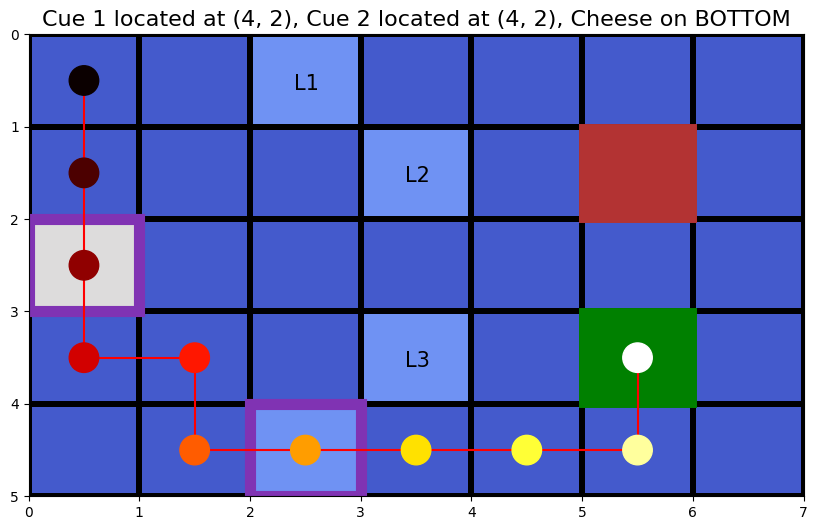

In [41]:
all_locations = np.vstack(history_of_locs).astype(float) # create a matrix containing the agent's Y/X locations over time (each coordinate in one row of the matrix)

fig, ax = plt.subplots(figsize=(10, 6))

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

# get generative process global parameters (the locations of the Cues, the reward condition, etc.)
cue1_loc, cue2_loc, reward_condition = my_env.cue1_loc, my_env.cue2_loc, my_env.reward_condition
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_loc = reward_locations[0] if reward_condition == "TOP" else reward_locations[1]

if reward_condition == "TOP":
    reward_top.set_edgecolor('g')
    reward_top.set_facecolor('g')
    reward_bottom.set_edgecolor([0.7, 0.2, 0.2])
    reward_bottom.set_facecolor([0.7, 0.2, 0.2])
elif reward_condition == "BOTTOM":
    reward_bottom.set_edgecolor('g')
    reward_bottom.set_facecolor('g')
    reward_top.set_edgecolor([0.7, 0.2, 0.2])
    reward_top.set_facecolor([0.7, 0.2, 0.2])
reward_top.set_zorder(1)
reward_bottom.set_zorder(1)

text_offsets = [0.4, 0.6]
cue_grid = np.ones(grid_dims)
cue_grid[cue1_loc[0],cue1_loc[1]] = 15.0
for ii, loc_ii in enumerate(cue2_locations):
  row_coord, column_coord = loc_ii
  cue_grid[row_coord, column_coord] = 5.0
  ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], cue2_loc_names[ii], fontsize = 15, color='k')

h.set_array(cue_grid.ravel())

cue1_rect = ax.add_patch(patches.Rectangle((cue1_loc[1],cue1_loc[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))
cue2_rect = ax.add_patch(patches.Rectangle((cue2_loc[1],cue2_loc[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))

ax.plot(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 'r', zorder = 2)

temporal_colormap = cm.hot(np.linspace(0,1,T+1))
dots = ax.scatter(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 450, c = temporal_colormap, zorder=3)

ax.set_title(f"Cue 1 located at {cue2_loc}, Cue 2 located at {cue2_loc}, Cheese on {reward_condition}", fontsize=16)


### Experimenting with different environmental structure

Try changing around the locations of the rewards, the cues, the agent's beliefs, etc. For example, below we'll change the location of the rewards, both in the generative model and the generative process.

In [42]:
# names of the reward conditions and their locations
reward_conditions = ["LEFT", "RIGHT"]
reward_locations = [(2, 2), (2, 4)] # DIFFERENT REWARD LOCATIONS

## reset `A[3]`, the reward observation model

A[3] = np.zeros([num_obs[3]] + num_states)
# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[3][0,rew_top_idx,:,:] = 0.0
A[3][1,rew_top_idx,:,0] = 1.0
A[3][2,rew_top_idx,:,1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" reward location
A[3][0,rew_bott_idx,:,:] = 0.0
A[3][1,rew_bott_idx,:,1] = 1.0
A[3][2,rew_bott_idx,:,0] = 1.0

class GridWorldEnv():

    def __init__(self,starting_loc = (4,0), cue1_loc = (2, 0), cue2 = 'L1', reward_condition = 'LEFT'):

        self.init_loc = starting_loc
        self.current_location = self.init_loc

        self.cue1_loc = cue1_loc
        self.cue2_name = cue2
        self.cue2_loc_names = ['L1', 'L2', 'L3', 'L4']
        self.cue2_loc = cue2_locations[self.cue2_loc_names.index(self.cue2_name)]

        self.reward_condition = reward_condition
        print(f'Starting location is {self.init_loc}, Reward condition is {self.reward_condition}, cue is located in {self.cue2_name}')

    def step(self,action_label):

        (Y, X) = self.current_location

        if action_label == "UP":

          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN":

          Y_new = Y + 1 if Y < (grid_dims[0]-1) else Y
          X_new = X

        elif action_label == "LEFT":
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT":
          Y_new = Y
          X_new = X +1 if X < (grid_dims[1]-1) else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X

        self.current_location = (Y_new, X_new) # store the new grid location

        loc_obs = self.current_location # agent always directly observes the grid location they're in

        if self.current_location == self.cue1_loc:
          cue1_obs = self.cue2_name
        else:
          cue1_obs = 'Null'

        if self.current_location == self.cue2_loc:
          cue2_obs = cue2_names[reward_conditions.index(self.reward_condition)+1]
        else:
          cue2_obs = 'Null'

        # @NOTE: here we use the same variable `reward_locations` to create both the agent's generative model (the `A` matrix) as well as the generative process.
        # This is just for simplicity, but it's not necessary -  you could have the agent believe that the Cheese/Shock are actually stored in arbitrary, incorrect locations.

        if self.current_location == reward_locations[0]:
          if self.reward_condition == 'LEFT':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        elif self.current_location == reward_locations[1]:
          if self.reward_condition == 'RIGHT':
            reward_obs = 'Cheese'
          else:
            reward_obs = 'Shock'
        else:
          reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs

    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        loc_obs = self.current_location
        cue1_obs = 'Null'
        cue2_obs = 'Null'
        reward_obs = 'Null'

        return loc_obs, cue1_obs, cue2_obs, reward_obs

In [43]:
my_agent = Agent(A = A, B = B, C = C, D = D, policy_len = 4)

my_env = GridWorldEnv(starting_loc = (0,0), cue1_loc = (2, 0), cue2 = 'L1', reward_condition = 'RIGHT')

loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.reset()

history_of_locs = [loc_obs]
obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

T = 10 # number of total timesteps

for t in range(T):

    qs = my_agent.infer_states(obs)

    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    loc_obs, cue1_obs, cue2_obs, reward_obs = my_env.step(choice_action)

    obs = [loc_list.index(loc_obs), cue1_names.index(cue1_obs), cue2_names.index(cue2_obs), reward_names.index(reward_obs)]

    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {reward_obs}')

Starting location is (0, 0), Reward condition is RIGHT, cue is located in L1
Re-initialized location to (0, 0)


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


Action at time 0: DOWN
Grid location at time 0: (1, 0)
Reward at time 0: Null
Action at time 1: DOWN
Grid location at time 1: (2, 0)
Reward at time 1: Null
Action at time 2: UP
Grid location at time 2: (1, 0)
Reward at time 2: Null


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


Action at time 3: RIGHT
Grid location at time 3: (1, 1)
Reward at time 3: Null
Action at time 4: UP
Grid location at time 4: (0, 1)
Reward at time 4: Null
Action at time 5: RIGHT
Grid location at time 5: (0, 2)
Reward at time 5: Null
Action at time 6: RIGHT
Grid location at time 6: (0, 3)
Reward at time 6: Null
Action at time 7: DOWN
Grid location at time 7: (1, 3)
Reward at time 7: Null
Action at time 8: DOWN
Grid location at time 8: (2, 3)
Reward at time 8: Null


ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
ValueError: Iterator is past the end


Action at time 9: RIGHT
Grid location at time 9: (2, 4)
Reward at time 9: Cheese


Text(0.5, 1.0, 'Cue 1 located at (0, 2), Cue 2 located at (0, 2), Cheese on RIGHT')

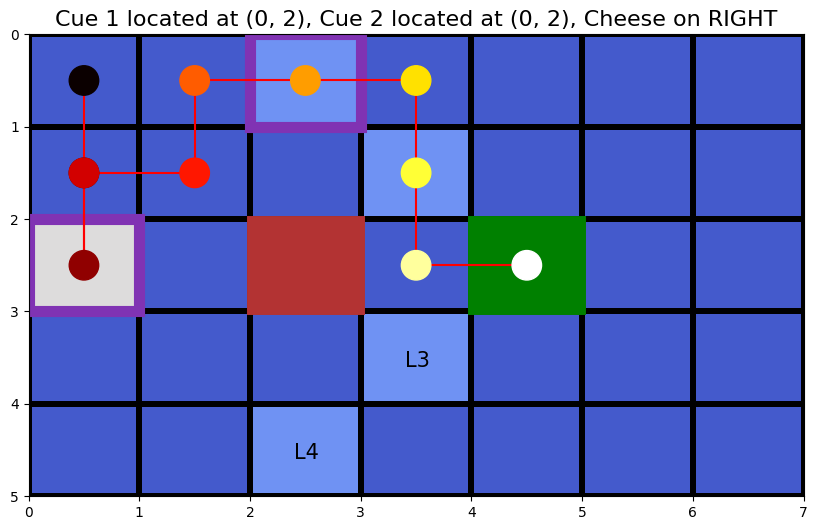

In [44]:

all_locations = np.vstack(history_of_locs).astype(float) # create a matrix containing the agent's Y/X locations over time (each coordinate in one row of the matrix)

fig, ax = plt.subplots(figsize=(10, 6))

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

# get generative process global parameters (the locations of the Cues, the reward condition, etc.)
cue1_loc, cue2_loc, reward_condition = my_env.cue1_loc, my_env.cue2_loc, my_env.reward_condition
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor='none'))
reward_loc = reward_locations[0] if reward_condition == "LEFT" else reward_locations[1]

if reward_condition == "LEFT":
    reward_top.set_edgecolor('g')
    reward_top.set_facecolor('g')
    reward_bottom.set_edgecolor([0.7, 0.2, 0.2])
    reward_bottom.set_facecolor([0.7, 0.2, 0.2])
elif reward_condition == "RIGHT":
    reward_bottom.set_edgecolor('g')
    reward_bottom.set_facecolor('g')
    reward_top.set_edgecolor([0.7, 0.2, 0.2])
    reward_top.set_facecolor([0.7, 0.2, 0.2])
reward_top.set_zorder(1)
reward_bottom.set_zorder(1)

text_offsets = [0.4, 0.6]
cue_grid = np.ones(grid_dims)
cue_grid[cue1_loc[0],cue1_loc[1]] = 15.0
for ii, loc_ii in enumerate(cue2_locations):
  row_coord, column_coord = loc_ii
  cue_grid[row_coord, column_coord] = 5.0
  ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], cue2_loc_names[ii], fontsize = 15, color='k')

h.set_array(cue_grid.ravel())

cue1_rect = ax.add_patch(patches.Rectangle((cue1_loc[1],cue1_loc[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))
cue2_rect = ax.add_patch(patches.Rectangle((cue2_loc[1],cue2_loc[0]),1.0,1.0,linewidth=8,edgecolor=[0.5, 0.2, 0.7],facecolor='none'))

ax.plot(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 'r', zorder = 2)

temporal_colormap = cm.hot(np.linspace(0,1,T+1))
dots = ax.scatter(all_locations[:,1]+0.5,all_locations[:,0]+0.5, 450, c = temporal_colormap, zorder=3)

ax.set_title(f"Cue 1 located at {cue2_loc}, Cue 2 located at {cue2_loc}, Cheese on {reward_condition}", fontsize=16)